In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [46]:
data = pd.read_csv('all_data.csv')

In [47]:
numeric = ['activity_duration','length_of_activity_in_minutes','promised_reward', 'gained_reward']

SEED=1
X_train, X_test, y_train, y_test = train_test_split(data.drop(['fraud', 'user'], axis=1),
                                                   data.fraud,
                                                   test_size=0.3,
                                                   random_state=SEED,
                                                   stratify=data.fraud)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2608064, 27), (2608064,), (1117743, 27), (1117743,))

In [48]:
scaler = StandardScaler()

X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

#### Мы выберем Площадь под кривой ROC (AUC)  и F1_score в качестве метрики для нашей задачи ML.
#### Что такое AUC ROC?
#### AUC - это площадь под кривой ROC. Он говорит о том, насколько модель способна различать классы. Чем выше AUC, тем лучше модель предсказывает 0 как 0 и 1 как 1. Кривая ROC построена с отношением TPR к FPR, где TPR находится на оси y, а FPR - на оси x.

#### F1-это средневзвешенное значение точности и полноты, поэтому эта оценка учитывает как ложные положительные, так и ложные отрицательные результаты. 

In [49]:
def evaluate_model(model, X, y):
    pred = model.predict(X)
    return f'{model.__class__.__name__}: ROC_AUC_SCORE - {np.round(roc_auc_score(pred, y), 3)}, F1_SCORE - {np.round(f1_score(pred, y), 3)}'

In [50]:
for model in [GaussianNB(),
              LogisticRegression(),
              DecisionTreeClassifier(),
              RandomForestClassifier(n_estimators=30, random_state=SEED, n_jobs=-1),
              XGBClassifier(n_estimators=30, seed=SEED, eval_metric='auc', objective='binary:logistic', n_jobs=-1)
              ]:
    model.fit(X_train, y_train)
    print(f'Train {evaluate_model(model, X_train, y_train)}')
    print(f'Test  {evaluate_model(model, X_test, y_test)}')
    print('\n')

Train GaussianNB: ROC_AUC_SCORE - 0.661, F1_SCORE - 0.549
Test  GaussianNB: ROC_AUC_SCORE - 0.661, F1_SCORE - 0.549


Train LogisticRegression: ROC_AUC_SCORE - 0.643, F1_SCORE - 0.318
Test  LogisticRegression: ROC_AUC_SCORE - 0.643, F1_SCORE - 0.318


Train DecisionTreeClassifier: ROC_AUC_SCORE - 0.876, F1_SCORE - 0.75
Test  DecisionTreeClassifier: ROC_AUC_SCORE - 0.693, F1_SCORE - 0.5


Train RandomForestClassifier: ROC_AUC_SCORE - 0.865, F1_SCORE - 0.756
Test  RandomForestClassifier: ROC_AUC_SCORE - 0.707, F1_SCORE - 0.516


Train XGBClassifier: ROC_AUC_SCORE - 0.709, F1_SCORE - 0.406
Test  XGBClassifier: ROC_AUC_SCORE - 0.707, F1_SCORE - 0.403




In [51]:
nb_p = {'var_smoothing': 1e-07}

log_p = {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs', 'penalty': 'l2'}

dtree_p = {'min_samples_split': 2,
           'min_samples_leaf': 5,
           'max_features': 20,
           'max_depth': 15,
           'class_weight': {1:0.7, 0:0.3}}

forest_p = {'n_estimators': 20,
            'min_samples_split': 2,
            'min_samples_leaf': 5,
            'max_features': 20,
            'max_depth': 15,
            'class_weight': {1:0.7, 0:0.3},
            'max_samples': 0.7,
            'n_jobs': -1,
            'random_state': SEED}

xgb_p = {'subsample': 0.7,
         'min_child_weight': 1,
         'max_depth': 15,
         'gamma': 0.5,
         'colsample_bytree': 0.7,
         'n_estimators': 20,
         'learning_rate': 0.1,
         'random_state': SEED,
         'eval_metric': 'auc',
         'n_jobs': -1,
         'objective': 'binary:logistic'}

In [52]:
for model in [GaussianNB(**nb_p),
              LogisticRegression(**log_p),
              DecisionTreeClassifier(**dtree_p),
              RandomForestClassifier(**forest_p),
              XGBClassifier(**xgb_p)
              ]:
    model.fit(X_train, y_train)
    print(f'Train {evaluate_model(model, X_train, y_train)}')
    print(f'Test  {evaluate_model(model, X_test, y_test)}')
    print('\n')

Train GaussianNB: ROC_AUC_SCORE - 0.661, F1_SCORE - 0.549
Test  GaussianNB: ROC_AUC_SCORE - 0.661, F1_SCORE - 0.549


Train LogisticRegression: ROC_AUC_SCORE - 0.669, F1_SCORE - 0.564
Test  LogisticRegression: ROC_AUC_SCORE - 0.669, F1_SCORE - 0.564


Train DecisionTreeClassifier: ROC_AUC_SCORE - 0.708, F1_SCORE - 0.617
Test  DecisionTreeClassifier: ROC_AUC_SCORE - 0.704, F1_SCORE - 0.612


Train RandomForestClassifier: ROC_AUC_SCORE - 0.712, F1_SCORE - 0.623
Test  RandomForestClassifier: ROC_AUC_SCORE - 0.708, F1_SCORE - 0.617


Train XGBClassifier: ROC_AUC_SCORE - 0.766, F1_SCORE - 0.465
Test  XGBClassifier: ROC_AUC_SCORE - 0.748, F1_SCORE - 0.442




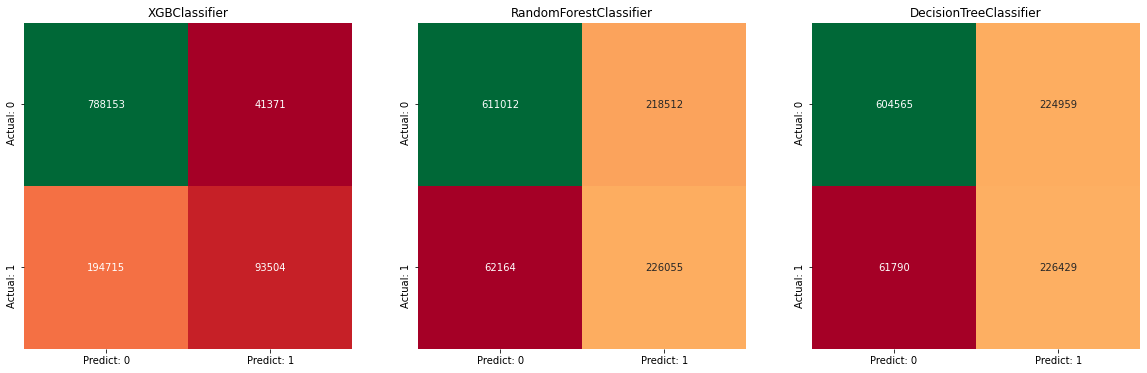

In [54]:
xgb = XGBClassifier(**xgb_p)
forest = RandomForestClassifier(**forest_p)
dtree = DecisionTreeClassifier(**dtree_p)

fig, ax = plt.subplots(1,3,figsize=(20,6))
for model, i in zip([xgb, forest, dtree], [0, 1, 2]):
    model.fit(X_train, y_train)
    cm = confusion_matrix(y_test, model.predict(X_test))
    conf_matrix = pd.DataFrame(data=cm, columns=['Predict: 0', 'Predict: 1'], index=['Actual: 0', 'Actual: 1'])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdYlGn', cbar=False, ax=ax[i]) \
        .set_title(f'{model.__class__.__name__}')

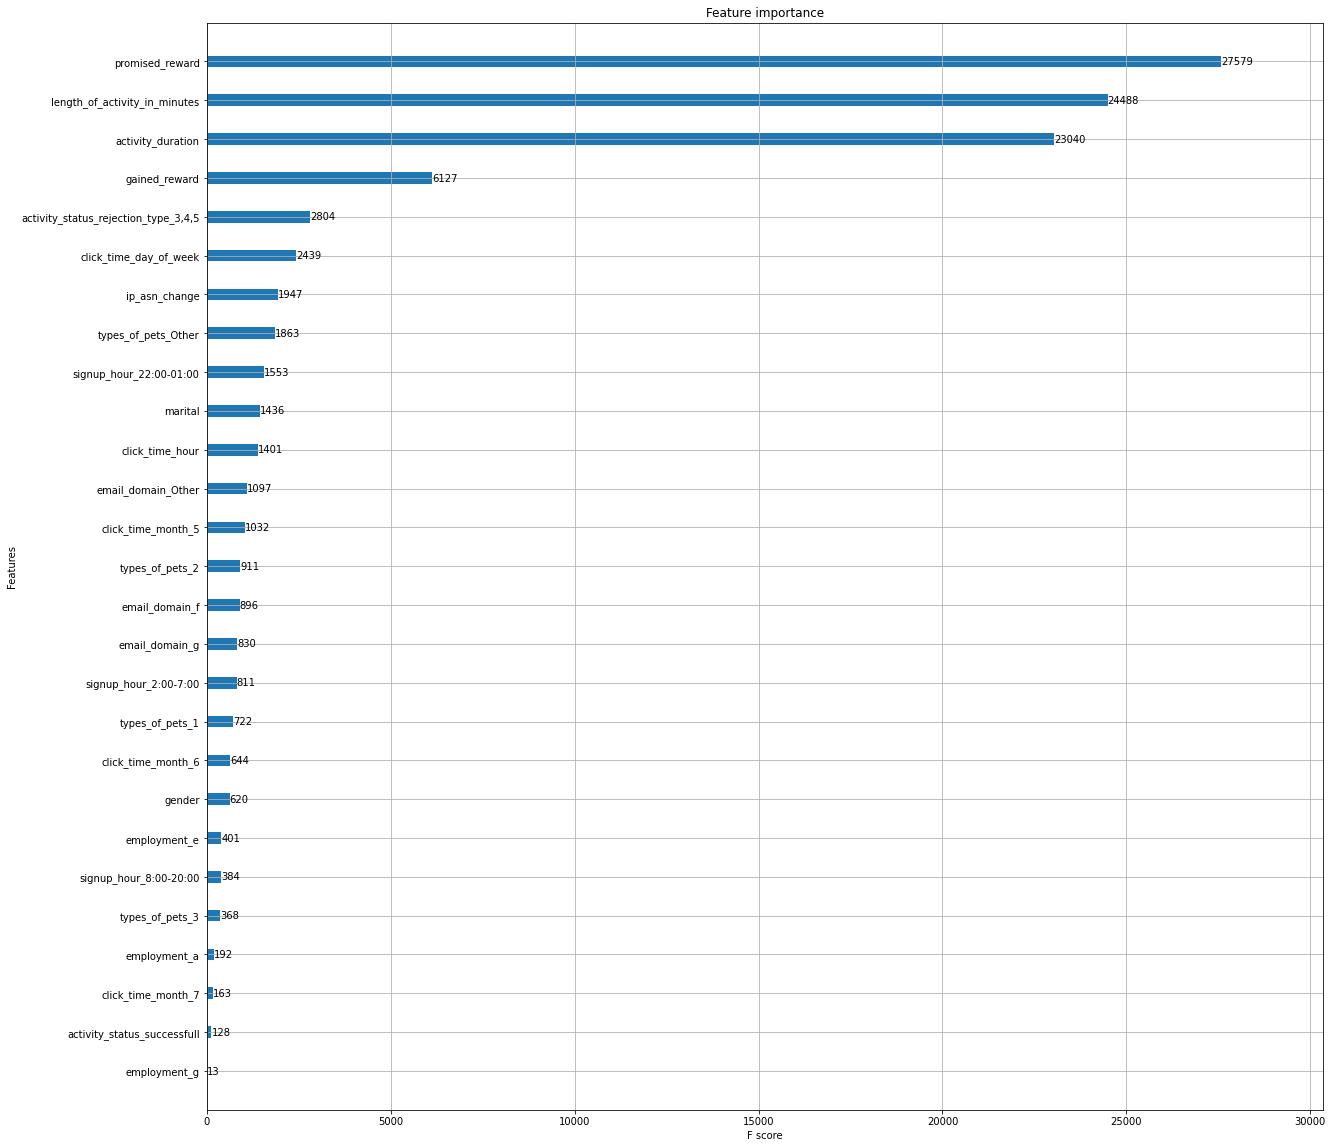

In [90]:
_, ax = plt.subplots(figsize=(20,20))
plot_importance(xgb, max_num_features=X_train.shape[1], height=0.3, ax=ax)
plt.show()

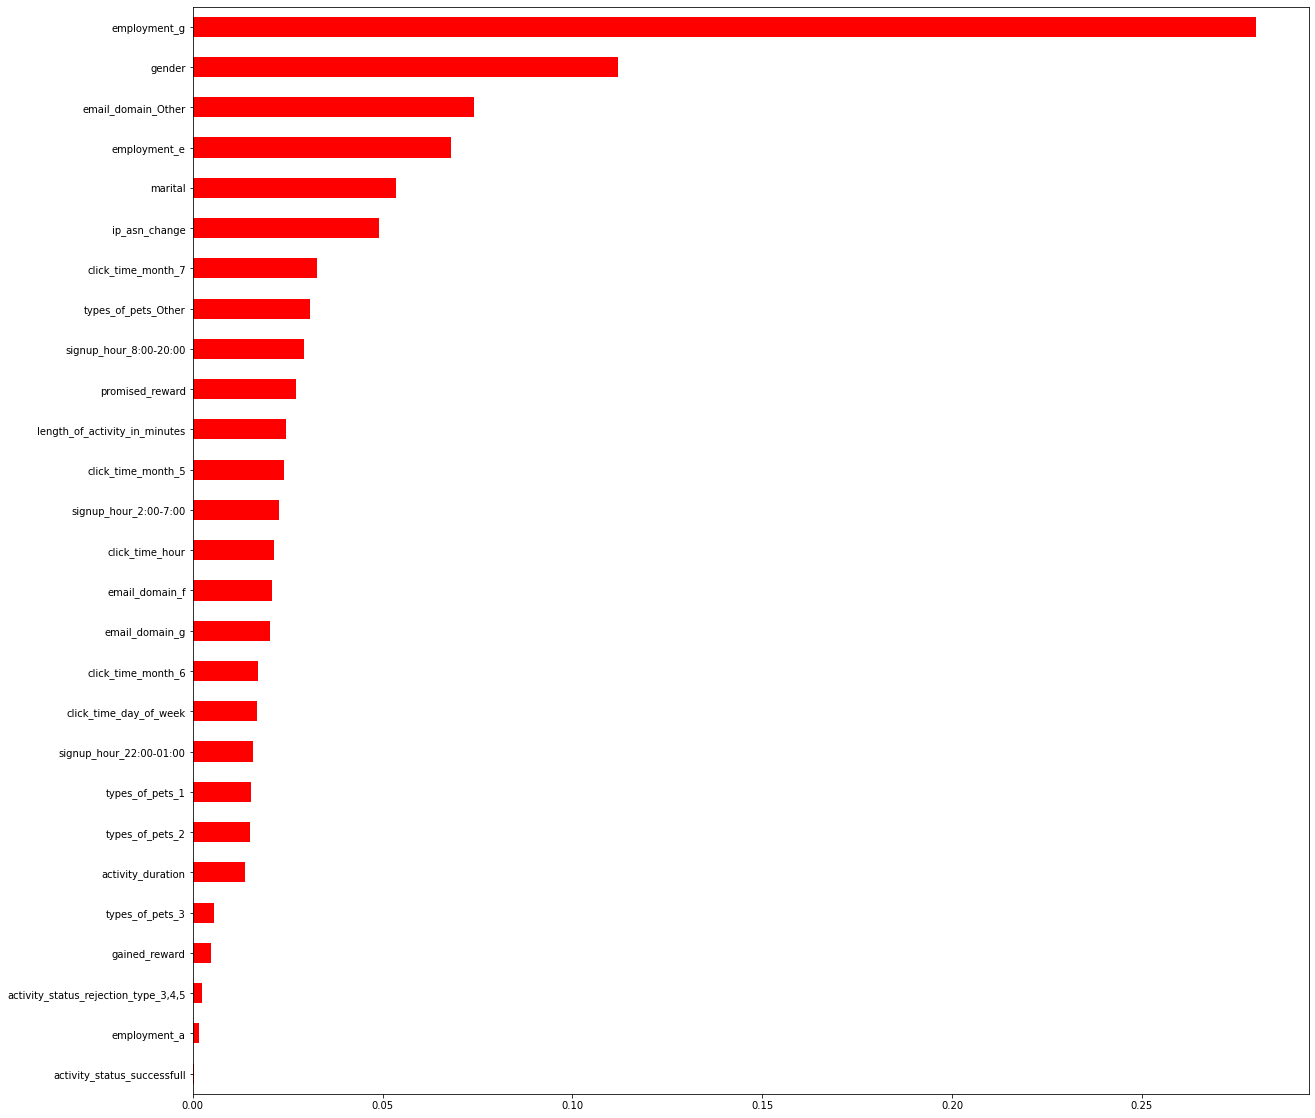

In [56]:
plt.figure(figsize=(20,20))
feat_import = pd.Series(forest.feature_importances_, index=X_train.columns).sort_values()
feat_import.plot(kind='barh', color='r')
plt.show()

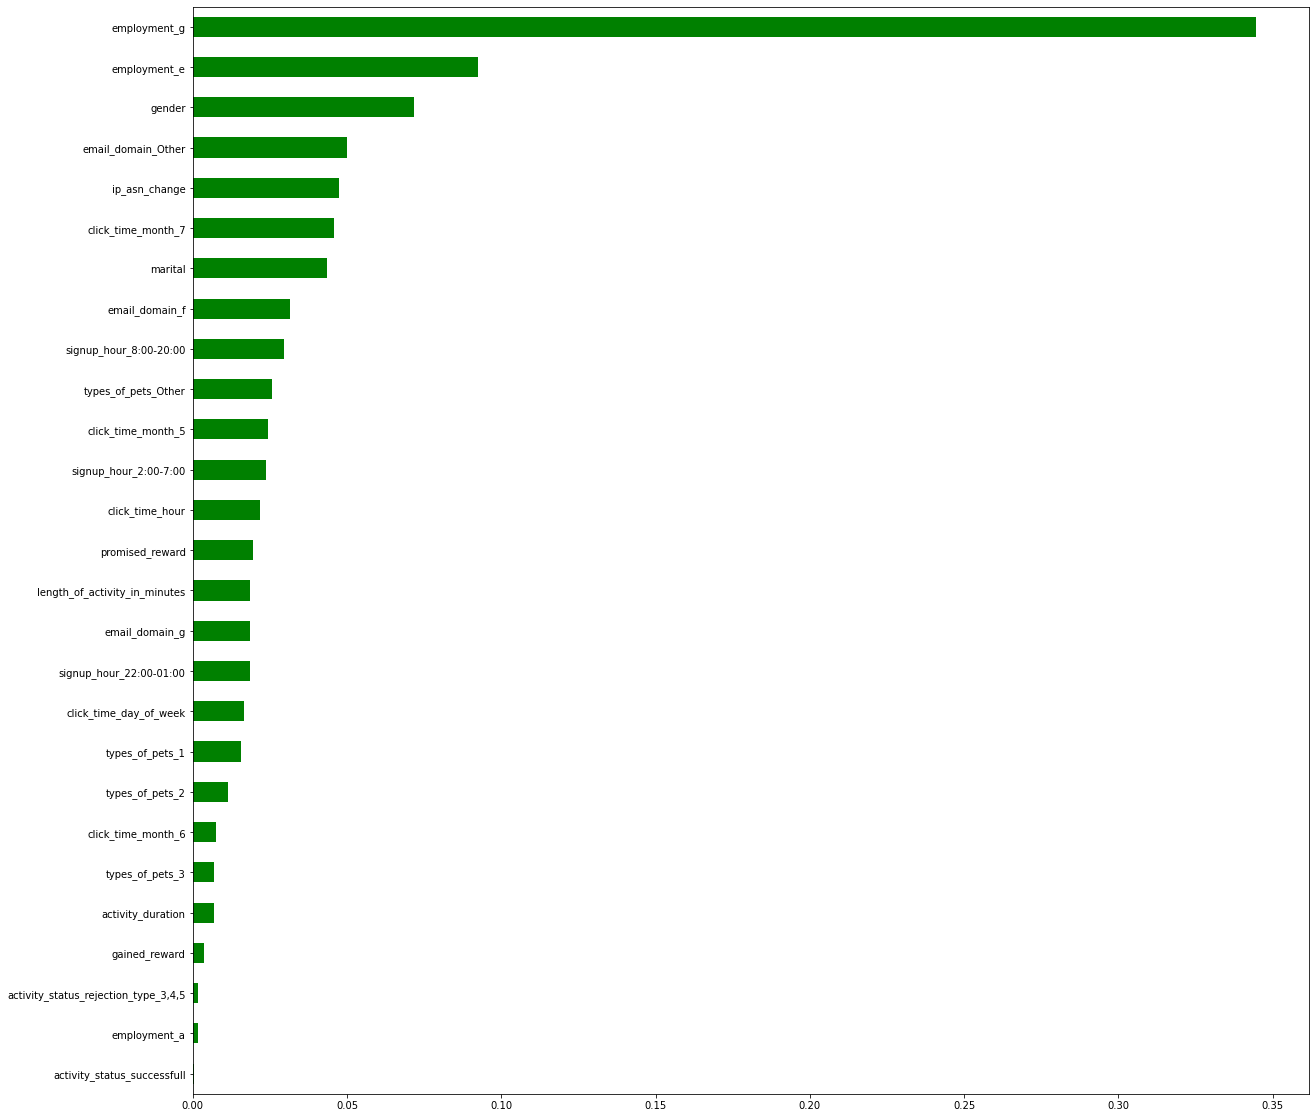

In [57]:
plt.figure(figsize=(20,20))
feat_import = pd.Series(dtree.feature_importances_, index=X_train.columns).sort_values()
feat_import.plot(kind='barh', color='g')
plt.show()

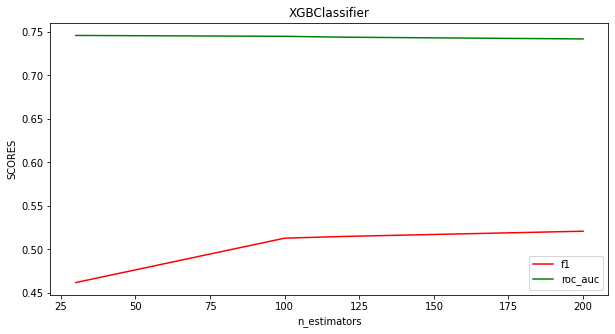

In [42]:
xgb_params = {'subsample': 0.7,
         'min_child_weight': 1,
         'max_depth': 15,
         'gamma': 0.5,
         'colsample_bytree': 0.7,
         'learning_rate': 0.1,
         'random_state': SEED,
         'eval_metric': 'auc',
         'objective': 'binary:logistic'}

f1, roc =[], []
n_list = [30, 100, 120, 200] 
for n in n_list:
    xgb = XGBClassifier(n_estimators=n, **xgb_params).fit(X_train, y_train)
    predict = xgb.predict(X_test)
    f1.append(np.round(f1_score(predict, y_test), 3))
    roc.append(np.round(roc_auc_score(predict, y_test), 3))
plt.figure(figsize=(10,5))
plt.plot(n_list, f1, color='r', label='f1')
plt.plot(n_list, roc, color='g', label='roc_auc')
plt.xlabel('n_estimators')
plt.ylabel('SCORES')
plt.title('XGBClassifier')
plt.legend()
plt.show()

In [64]:
forest_params = {'min_samples_split': 2,
            'min_samples_leaf': 5,
            'max_features': 20,
            'max_depth': 15,
            'max_samples': 0.7,
            'class_weight': {1:0.7, 0:0.3},
            'random_state': SEED}

f1, roc =[], []
n_list = [70, 100, 120, 150] 
for n in n_list:
    forest = RandomForestClassifier(n_estimators=n, **forest_params).fit(X_train, y_train)
    predict = forest.predict(X_test)
    f1.append(np.round(f1_score(predict, y_test), 3))
    roc.append(np.round(roc_auc_score(predict, y_test), 3))
plt.figure(figsize=(10,5))
plt.plot(n_list, f1, color='r', label='f1')
plt.plot(n_list, roc, color='g', label='roc_auc')
plt.xlabel('n_estimators')
plt.ylabel('SCORES')
plt.title('RandomForestClassifier')
plt.legend()
plt.show()



# Feature Selection



In [59]:
for n in [10, 15, 20, 22, 25]:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train, y_train)
    X_test_pca = pca.transform(X_test)
    
    dt_p = dtree_params = {'min_samples_split': 2,
           'min_samples_leaf': 5,
           'max_features': n,
           'max_depth': n-5,
           'class_weight': {1:0.7, 0:0.3},
           'random_state': SEED}

    dt = DecisionTreeClassifier(**dt_p).fit(X_train_pca, y_train)
    print(evaluate_model(dt, X_train_pca, y_train))
    print(evaluate_model(dt, X_test_pca, y_test))
    print('\n')

DecisionTreeClassifier: ROC_AUC_SCORE - 0.664, F1_SCORE - 0.556
DecisionTreeClassifier: ROC_AUC_SCORE - 0.664, F1_SCORE - 0.556


DecisionTreeClassifier: ROC_AUC_SCORE - 0.688, F1_SCORE - 0.591
DecisionTreeClassifier: ROC_AUC_SCORE - 0.687, F1_SCORE - 0.589


DecisionTreeClassifier: ROC_AUC_SCORE - 0.705, F1_SCORE - 0.615
DecisionTreeClassifier: ROC_AUC_SCORE - 0.699, F1_SCORE - 0.606


DecisionTreeClassifier: ROC_AUC_SCORE - 0.711, F1_SCORE - 0.622
DecisionTreeClassifier: ROC_AUC_SCORE - 0.7, F1_SCORE - 0.607


DecisionTreeClassifier: ROC_AUC_SCORE - 0.718, F1_SCORE - 0.633
DecisionTreeClassifier: ROC_AUC_SCORE - 0.701, F1_SCORE - 0.607




In [60]:
rfe = RFE(dtree, n_features_to_select=20)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

dtree.fit(X_train_rfe, y_train)

print(evaluate_model(dtree, X_train_rfe, y_train))
print(evaluate_model(dtree, X_test_rfe, y_test))

DecisionTreeClassifier: ROC_AUC_SCORE - 0.709, F1_SCORE - 0.618
DecisionTreeClassifier: ROC_AUC_SCORE - 0.705, F1_SCORE - 0.613


Train DecisionTreeClassifier: ROC_AUC_SCORE - 0.709, F1_SCORE - 0.618
Test  DecisionTreeClassifier: ROC_AUC_SCORE - 0.705, F1_SCORE - 0.613


Train RandomForestClassifier: ROC_AUC_SCORE - 0.711, F1_SCORE - 0.621
Test  RandomForestClassifier: ROC_AUC_SCORE - 0.707, F1_SCORE - 0.616


Train XGBClassifier: ROC_AUC_SCORE - 0.767, F1_SCORE - 0.547
Test  XGBClassifier: ROC_AUC_SCORE - 0.745, F1_SCORE - 0.517




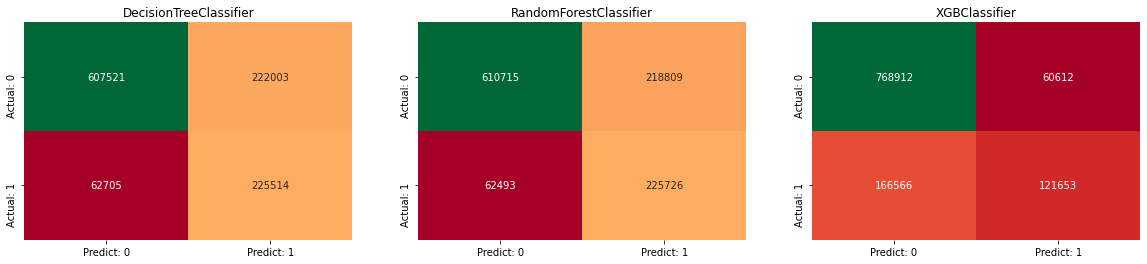

In [63]:
dtree_params = {'min_samples_split': 2,
           'min_samples_leaf': 5,
           'max_features': 20,
           'max_depth': 15,
           'class_weight': {1:0.7, 0:0.3},
           'random_state': SEED}

forest_params = {'n_estimators': 100,
            'min_samples_split': 2,
            'min_samples_leaf': 5,
            'max_features': 20,
            'max_depth': 15,
            'class_weight': {1:0.7, 0:0.3},
            'max_samples': 0.7,
            'n_jobs': -1,
            'random_state': SEED}

xgb_params = {'subsample': 0.7,
         'min_child_weight': 1,
         'max_depth': 15,
         'gamma': 0.5,
         'colsample_bytree': 0.7,
         'n_estimators': 100,
         'learning_rate': 0.1,
         'random_state': SEED,
         'eval_metric': 'auc',
         'n_jobs': -1,
         'objective': 'binary:logistic'}

Dtree = DecisionTreeClassifier(**dtree_params)
Rforest = RandomForestClassifier(**forest_params)
Xgb =  XGBClassifier(**xgb_params)

fig, ax = plt.subplots(1,3,figsize=(20,4))

for model, i in zip([Dtree, Rforest, Xgb], [0, 1, 2]):
    model.fit(X_train_rfe, y_train)
    
    cm = confusion_matrix(y_test, model.predict(X_test_rfe))
    conf_matrix = pd.DataFrame(data=cm, columns=['Predict: 0', 'Predict: 1'], index=['Actual: 0', 'Actual: 1'])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdYlGn', cbar=False, ax=ax[i]) \
        .set_title(f'{model.__class__.__name__}')
    
    print(f'Train {evaluate_model(model, X_train_rfe, y_train)}')
    print(f'Test  {evaluate_model(model, X_test_rfe, y_test)}')
    print('\n')

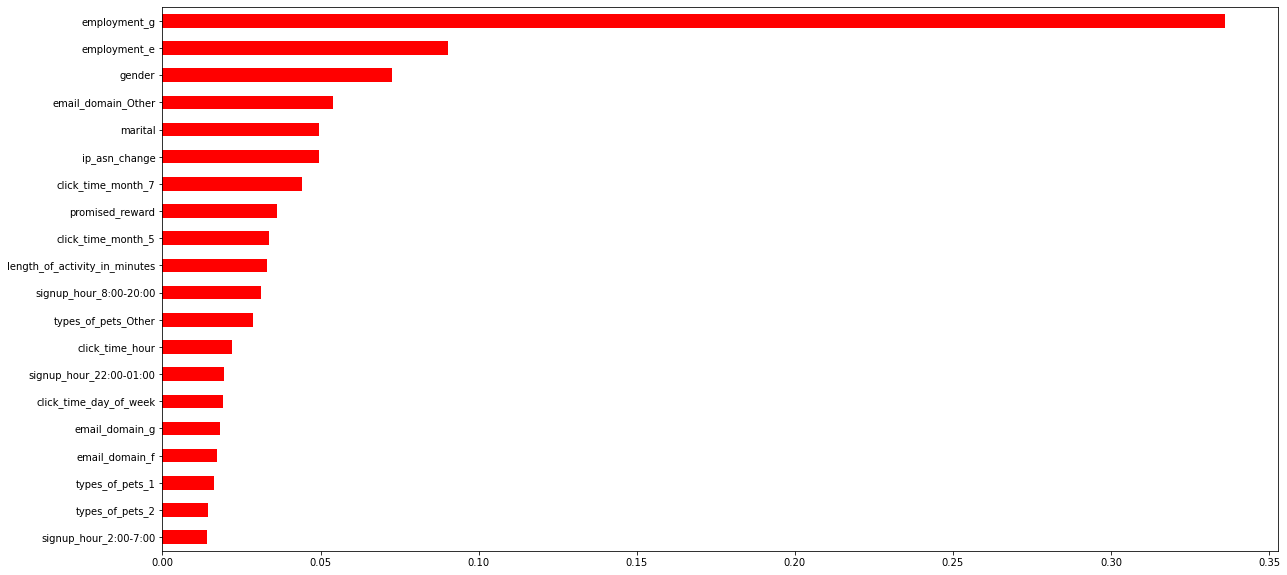

<Figure size 432x288 with 0 Axes>

In [87]:
columns = []
for item, column in zip(rfe.support_, X_train.columns):
    if item:
        columns.append(column)

plt.figure(figsize=(20,10))
feat_import = pd.Series(Rforest.feature_importances_, index=columns).sort_values()
feat_import.plot(kind='barh', color='r')
plt.show()
plt.savefig('RandomForest_feature_importans.png')

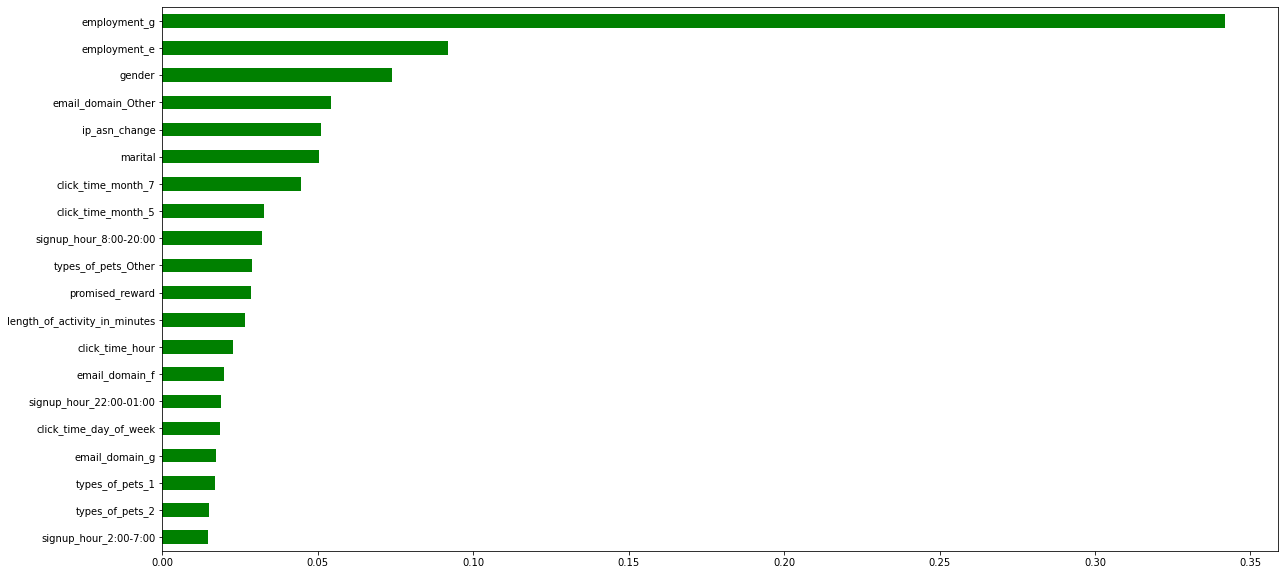

<Figure size 432x288 with 0 Axes>

In [86]:
plt.figure(figsize=(20,10))
feat_import = pd.Series(Dtree.feature_importances_, index=columns).sort_values()
feat_import.plot(kind='barh', color='g')
plt.show()
plt.savefig('DecisionTree_feature_importans.png')

## Выводы:
### В этой задаче нам важно уменьшить FalseNegative. 
### С данной задачей хорошо справляются DecisionTreeClassifier и RandomForestClassifier.
### У них качество почти одинаковое на и на train и на test, но у DecisionTreeClassifier скорость выполнение гораздо быстрое, поэтому поэтому в качестве итоговой модели выберем ее.

### ROC(AUC) score  train - 0.709, test - 0.705
###               F1 score  train - 0.618, test - 0.613